# Deep Learning Project - Recognizing traffic signs
## Introduction  
Computer vision is becoming a vital part of our daily lives. Its application helps protect our identity and the nation's security by using facial recognition. It makes autonomous driving possible by teaching the machines to recognize danger. However, the technology is far from reliable. Machines lack the moral values, intuition, and experience to steadily make the best situational decisions as quickly as we do. The smallest mistakes in code can lead to the most devastating accidents and consequences. That is why continuous research, data acquisition, and development is essential in improving computer vision applications and building safer self-driving vehicles.  
  
There are many factors that need to be considered when training a car to navigate itself, one of which is traffic signs. Several types of traffic signs regulate the road to ensure safety for the drivers, such as stop signs, no turn left/right, vehicle height restrictions, speed limits, traffic signals, etc. When it comes to traffic signs recognition, the goal is to identify which class or category the sign belongs to.  
  
This project builds a neural network model that does exactly that: Use computer vision to identify the traffic sign images and classify them into their respective classes. 

### Overview  
1. Exploratory Data Analysis
2. Model construction using convolutional neural network
3. Training and validation
4. Model testing using the test dataset  

### 1. EDA  
The dataset is provided by kaggle and consists of over 50,000 images of different traffic signs with 43 different classes. Each class consists of few to many images.  
We will import necessary packages, load the data, and examine the dataset in more detail.

In [62]:
#Import packages
import seaborn as sns
import random
from matplotlib.image import imread
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [63]:
# Save the csv files as dataframe
path = "../input/gtsrb-german-traffic-sign/"
meta = path + "Meta.csv"
test = path + "Test.csv"
train = path + "Train.csv"
df_meta = pd.read_csv(meta, delimiter = ',', nrows = None)
df_test = pd.read_csv(test)
df_train = pd.read_csv(train)

meta_row, meta_col = df_meta.shape
test_row, test_col = df_test.shape
train_row, train_col = df_train.shape

print(f'Meta data has {meta_row} rows and {meta_col} columns')
print(f'Test set has {test_row} rows and {test_col} columns')
print(f'Train set has {train_row} rows and {train_col} columns')
print(df_meta.describe())

Meta data has 43 rows and 5 columns
Test set has 12630 rows and 8 columns
Train set has 39209 rows and 8 columns
         ClassId    ShapeId    ColorId
count  43.000000  43.000000  43.000000
mean   21.000000   0.790698   0.511628
std    12.556539   0.803508   0.935340
min     0.000000   0.000000   0.000000
25%    10.500000   0.000000   0.000000
50%    21.000000   1.000000   0.000000
75%    31.500000   1.000000   1.000000
max    42.000000   4.000000   3.000000


By observing the number of rows in the meta dataset, we know that there are a total of 43 classes, each class with 4 features: ClassId, ShapeId, ColorId, and SignId.
- ClassId simply represents the class of the traffic sign.  
- ShapeId has integer values ranging from 0 to 4 (0-triangle, 1-circle, 2-diamond, 3-hexagon, 4-inverse triangle)  
- ColorId has integer values ranging from 0 to 3 (0-red, 1-blue, 2-yellow, 3-white)  
- SignId are values set by Ukranian Traffic Rule and ranges from 1.1  to 3.3.  

The test set has 12630 images, and the training set has 39209 images, both with 8 features.  
Let's look at the first few lines of the meta dataset.

In [64]:
df_meta.head()

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


The meta dataset simply holds information of the corresponding metadata images for reference.  
It seems to contain the class, shape, color, and sign indices of the metadata images.  
A visual representation of the distribution and frequency would help better understand the data.


<AxesSubplot:xlabel='ClassId', ylabel='Count'>

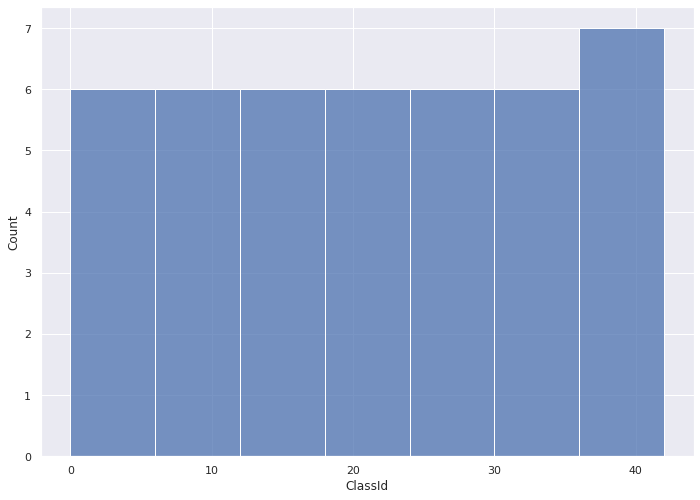

In [65]:
# Histogram of each feature
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data = df_meta, x = "ClassId")

'ClassId' feature is evenly distributed, which makes sense because it is taken from the meta dataset that contains unique information for each of the 43 classes.

<AxesSubplot:xlabel='ShapeId', ylabel='Count'>

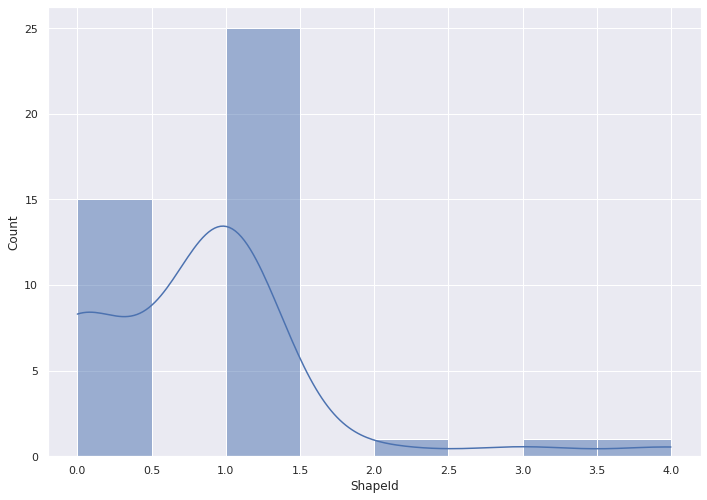

In [66]:
# Histogram of ShapeId
sns.histplot(data = df_meta, x = "ShapeId", kde=True)

The kernel density estimation is added to better visualize the distribution. We can see that ShapeId feature is most common in values below 1.5. These can be regarded as the most common road signs.

<AxesSubplot:xlabel='ColorId', ylabel='Count'>

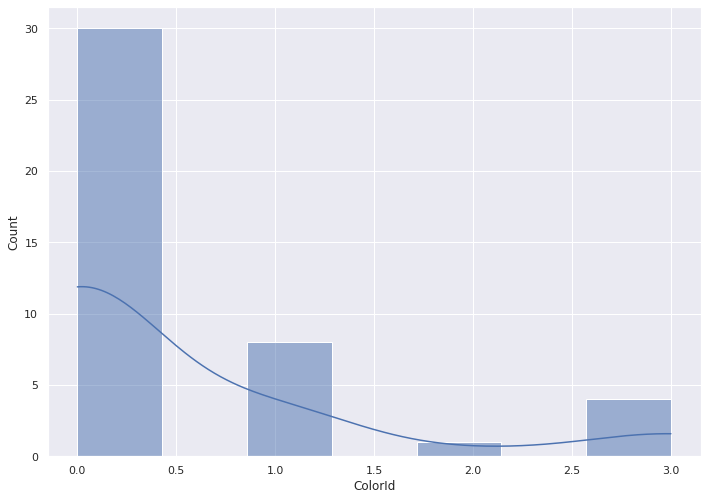

In [67]:
sns.histplot(data = df_meta, x = "ColorId", kde = True)

Similar to the ShapeId, the ColorId feature has the lower values more common compared to numbers above 1.0, with a noticeable minimum occuring at around 2.0 which happens to be yellow. This can be associated with the most dominant color that comprises the common traffic signs.

<AxesSubplot:xlabel='SignId', ylabel='Count'>

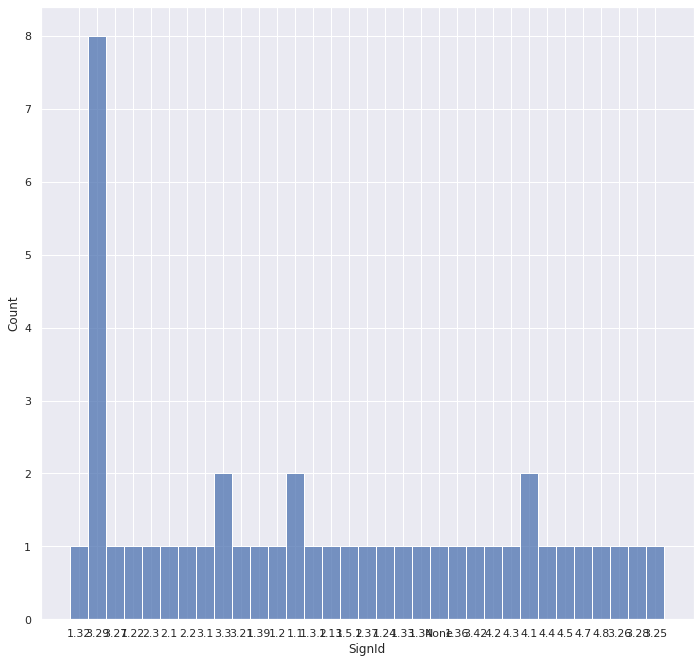

In [68]:
sns.set(rc={'figure.figsize':(11.7,11.27)})
sns.histplot(data = df_meta, x = "SignId")

The histogram for the SignId feature has a single value near the minimum, which is also very similar to the color and shape features from above. Looking at these histograms it is possible that some of the signs share similar properties with one another.  
For example, warning and caution signs are more yellow and red, while neutral messages such as welcome and landmark signs are white or green.

Now we will see if the features are correlated in any way.

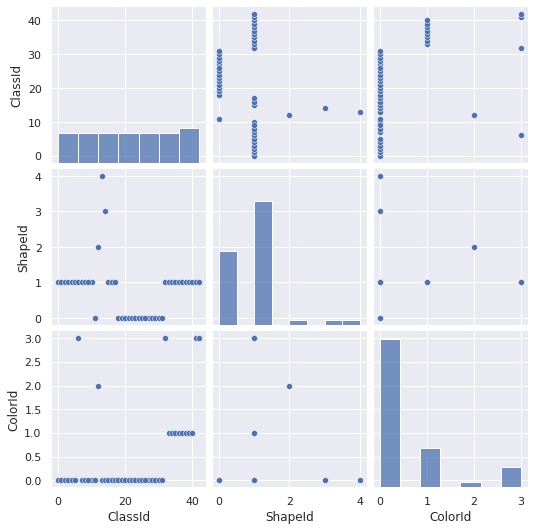

In [69]:
sns.pairplot(df_meta)

None of the pairplots show any noticeable (or meaningful) correlation except for shape and color, which itself seem to exhibit a step-function-like behavior. Since shapes are quite distinct when it comes to traffic signs, the indices may also show intervals rather than a continuous change which may be what causes such behavior.

<AxesSubplot:>

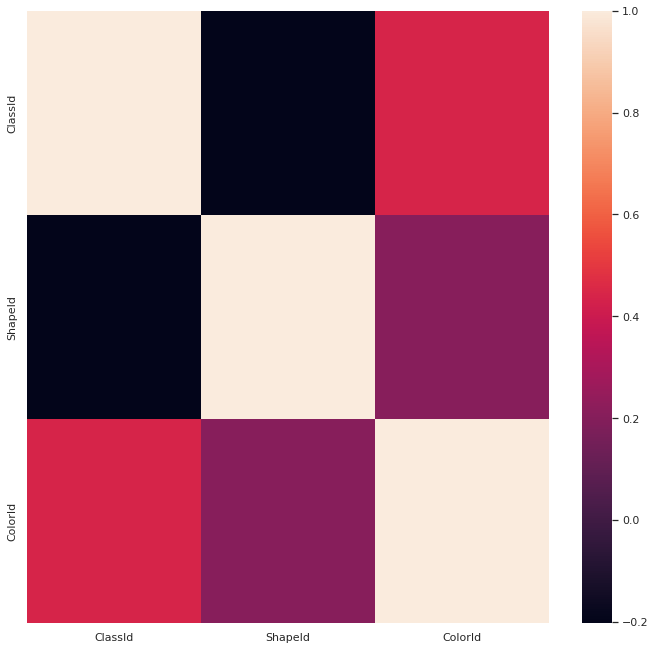

In [70]:
corr_matrix = df_meta.corr()
sns.heatmap(corr_matrix)

ShapeId - ClassId pair show 0 correlation, while ColorId appears to have some correlation with both ClassId and ShapeId. This correlation coefficient is likely from the several images being within the same class, such as those that represent danger, caution, and construction zones.  
  
Now let's look at the train and test sets.

In [71]:
df_train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


The training set dataframe contains information regarding each of the traffic sign's physical specifications, properties, and class.

array([[<AxesSubplot:title={'center':'Width'}>,
        <AxesSubplot:title={'center':'Height'}>,
        <AxesSubplot:title={'center':'Roi.X1'}>],
       [<AxesSubplot:title={'center':'Roi.Y1'}>,
        <AxesSubplot:title={'center':'Roi.X2'}>,
        <AxesSubplot:title={'center':'Roi.Y2'}>],
       [<AxesSubplot:title={'center':'ClassId'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

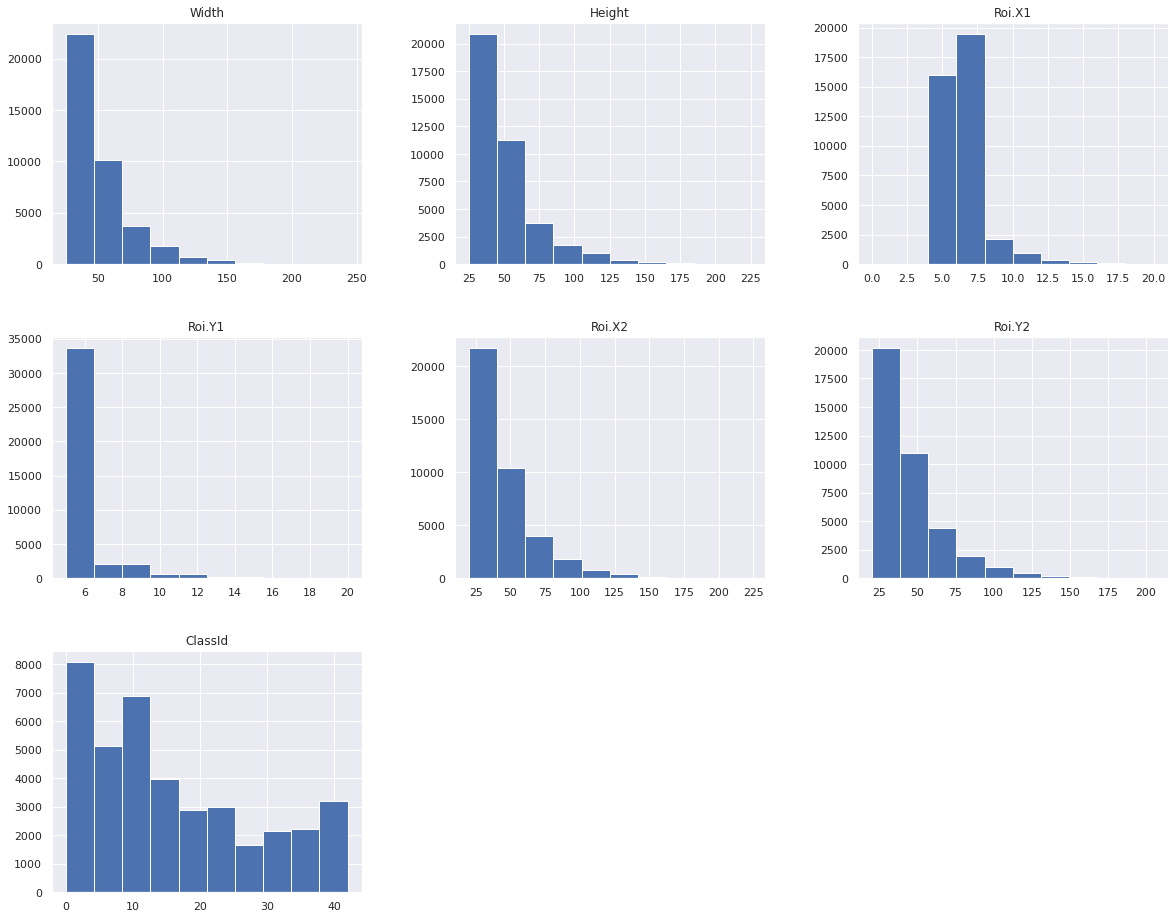

In [72]:
#Plot histogram/bar graphs, and correlation plot
df_train.hist(bins=10, figsize=(20, 16))

We can observe that all the histogram plots are except for ClassId have an exponential distribution.  
The histogram for ClassId shows a somewhat exponential curve, but only up until 30 and increases again, exhibiting an inverted bell shape.

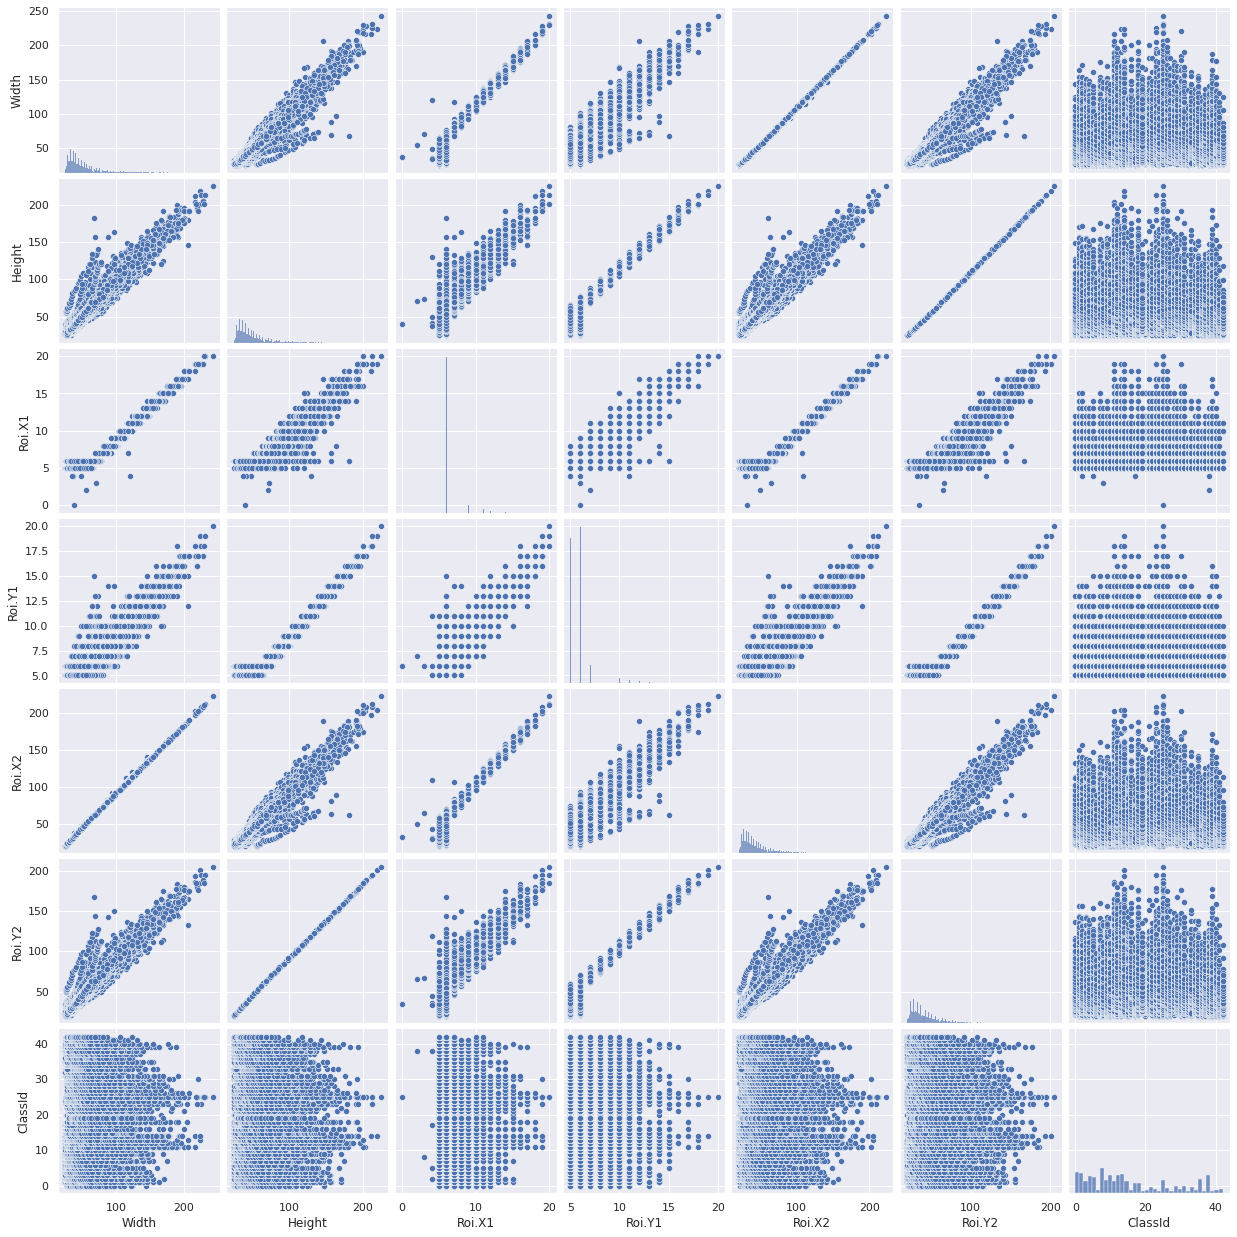

In [73]:
sns.pairplot(df_train)

<AxesSubplot:>

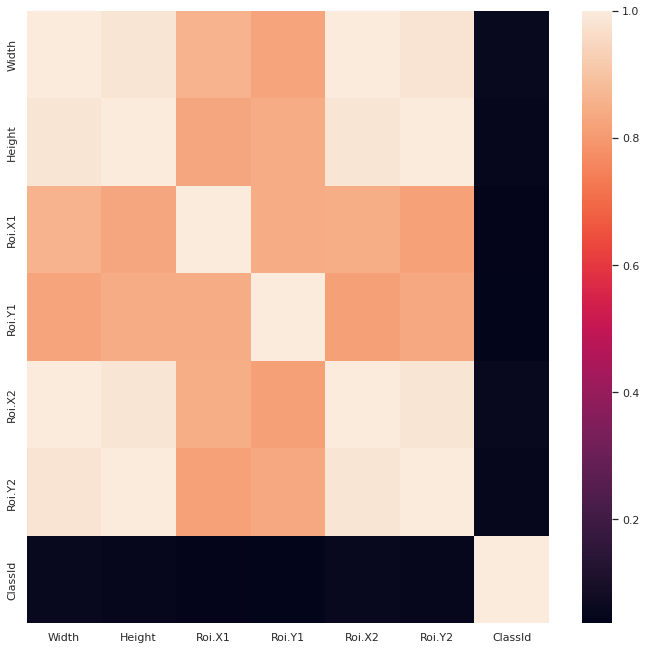

In [74]:
corr_matrix = df_train.corr()
sns.heatmap(corr_matrix)

Most of the pairplots and the heatmap show a linear and positive correlation.  
This is expected because most of the features are physical descriptors of the image such as coordinates and absolute lengths of the dimensions,  
which will have a directly proportional relationship to each other. The plots with little to no correlation are ones with ClassId in either of the pair.

As the final step in the exploratory analysis, we need to store the actual training and test images and their labels into lists.  
In order to do so, the list will first be converted into arrays to allow model construction. 

In [75]:
#initiate list
data = []
labels = []
classes = 43
work_path = "../input/gtsrb-german-traffic-sign/"

In [76]:
# Get images and their respective labels from directory
for i in range(classes):
    path = os.path.join(work_path, 'Train', str(i))
    imgs = os.listdir(path)
    
    for a in imgs:
        image = Image.open(path + '//' + a)
        image = image.resize((30, 30))
        image = np.array(image)
        data.append(image)
        labels.append(i)

data = np.array(data)
labels = np.array(labels)

In [77]:
print(data.shape, labels.shape)

(39209, 30, 30, 3) (39209,)


The training set has 39209 images with size 30 x 30 x 3. This means that each image's size is 30x30 pixels and RGB color. To verify, let's take a look at a few images from the test set.  

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


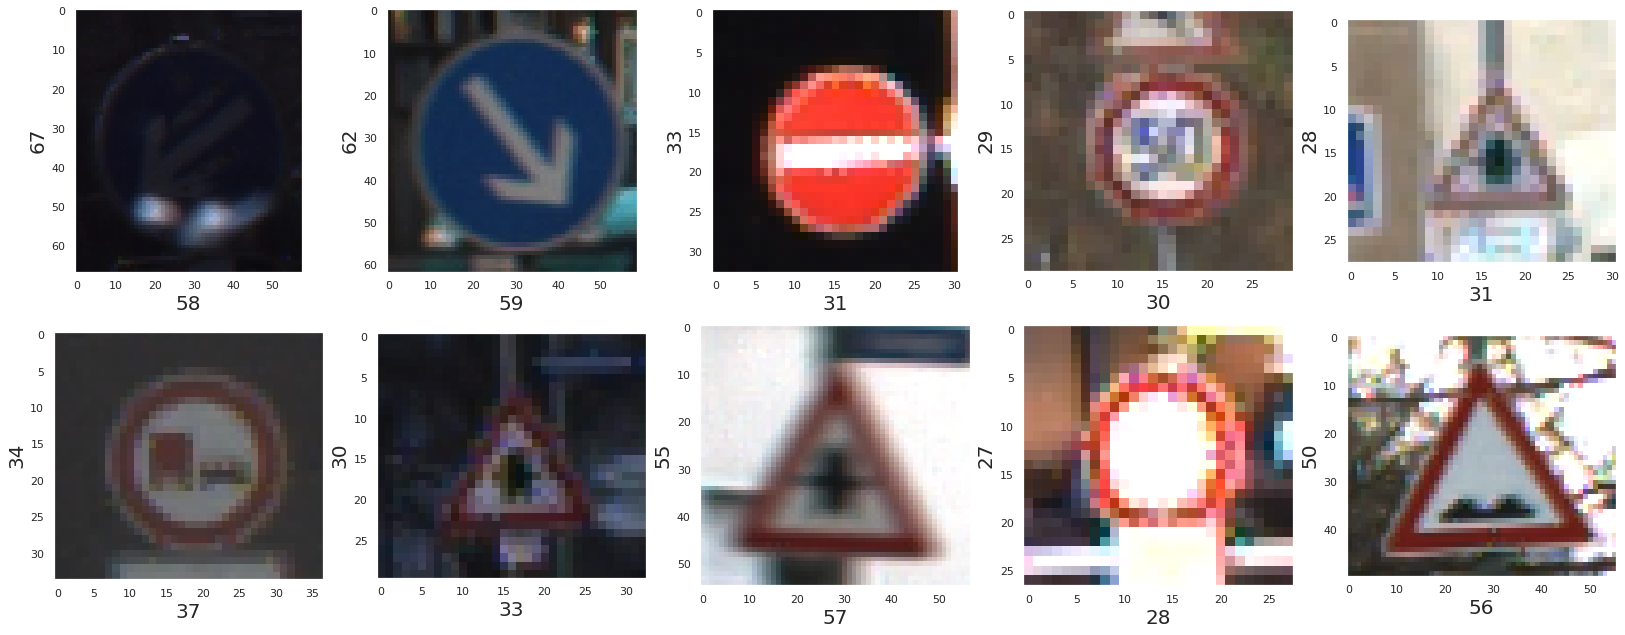

In [78]:
#Inspect a few images
test_imgs = df_test["Path"].values

plt.figure(figsize = (28, 28))

for i in range(1, 11):
    plt.subplot(5, 5, i)
    rand_img = work_path + random.choice(test_imgs)
    img = imread(rand_img)
    plt.imshow(img)
    plt.grid(b=None)
    plt.xlabel(img.shape[1], fontsize = 20) # Display image width
    plt.ylabel(img.shape[0], fontsize = 20) # Display image height

All we have left to do now is to split the data into training and test sets using the sklearn package.  
Also, the labels will be converted to categorical data.  

In [79]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 42)

y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

The data is fully prepared for model building!

### 2. Model Construction  
Convolutional neural network, or CNN, is known to perform well in image classification.  
The model architecture will a total of:  

- Two Conv2D layers
- Two MaxPool2D layers
- Three Dropout layers
- One Flatten layer
- One Fully connected layer
- Dense layer (final)  
  
The model will be compiled using Adam optimizer and loss function set to categorical crossentropy for multiple classes.

In [80]:
# Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

# Compile
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

### 3. Training and Validation  
Now that the model construction is complete, it will be trained using our training dataset and model.fit() method.

In [81]:
epochs = 15
history = model.fit(X_train, y_train, batch_size = 64, epochs=epochs, validation_data = (X_test, y_test))

Epoch 1/15
491/491 [==============================] - 3s 5ms/step - loss: 2.0075 - accuracy: 0.5258 - val_loss: 0.3511 - val_accuracy: 0.9143
Epoch 2/15
491/491 [==============================] - 2s 5ms/step - loss: 0.5173 - accuracy: 0.8620 - val_loss: 0.1287 - val_accuracy: 0.9723
Epoch 3/15
491/491 [==============================] - 3s 5ms/step - loss: 0.3203 - accuracy: 0.9125 - val_loss: 0.0946 - val_accuracy: 0.9795
Epoch 4/15
491/491 [==============================] - 2s 5ms/step - loss: 0.2268 - accuracy: 0.9373 - val_loss: 0.0630 - val_accuracy: 0.9847
Epoch 5/15
491/491 [==============================] - 3s 5ms/step - loss: 0.1997 - accuracy: 0.9452 - val_loss: 0.0736 - val_accuracy: 0.9823
Epoch 6/15
491/491 [==============================] - 2s 5ms/step - loss: 0.1682 - accuracy: 0.9536 - val_loss: 0.0511 - val_accuracy: 0.9881
Epoch 7/15
491/491 [==============================] - 2s 5ms/step - loss: 0.1628 - accuracy: 0.9562 - val_loss: 0.0417 - val_accuracy: 0.9892
Epoch 

The model scored roughly 96% in accuracy on the training set.

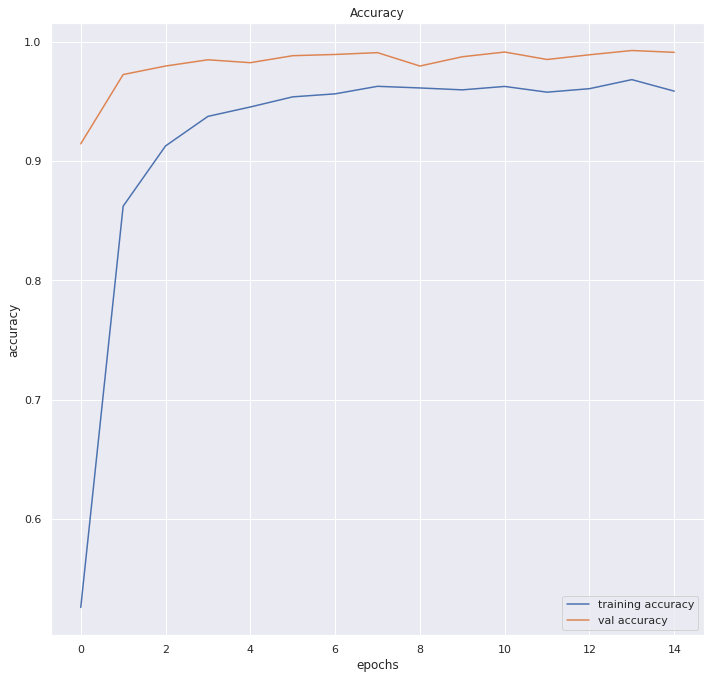

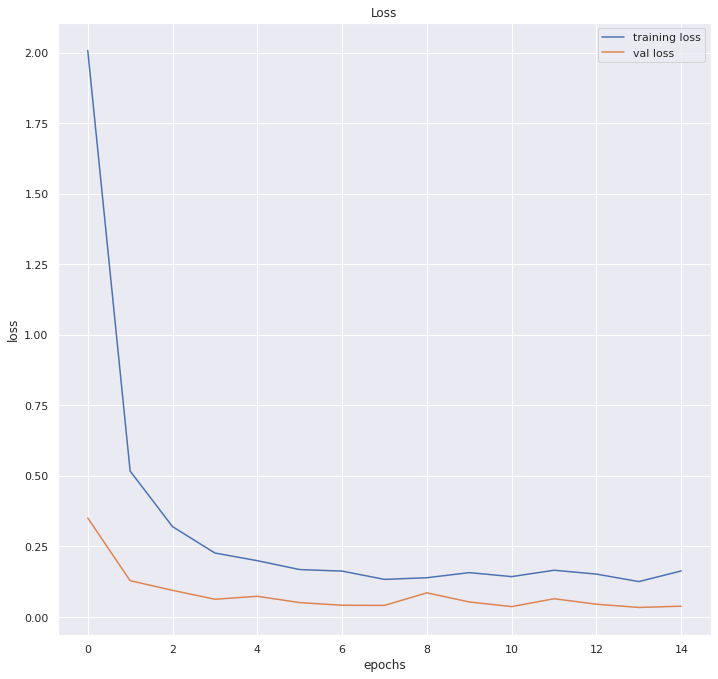

In [82]:
# Plot accuracy vs loss graph
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

### 4. Test model with test set  
In the exploratory data analysis section, the training and test dataframes contained details of the actual images and their labels.  
The test dataset will be prepared for model prediction using similar procedures from the first section.

In [83]:
test_labels = df_test["ClassId"].values
test_imgs = df_test["Path"].values

data = []

for img in test_imgs:
    img_path = work_path + img
    image = Image.open(img_path)
    image = image.resize((30, 30))
    data.append(np.array(image))

X_test = np.array(data)
yhat = np.argmax(model.predict(X_test), axis = 1)
print("accuracy: ", accuracy_score(test_labels, yhat))

accuracy:  0.9617577197149644


The model prediction accuracy came out to about 95%, similar to the training set.

In [84]:
model.save('trafficsign_classifier.h5')

### Evaluation, conclusion, reflection
Although there were few explanations regarding the dataset, the EDA procedure provided sufficient intuition to allow for appropriate data conversion, cleaning, and handling of outliers. Overall, the dataset was mostly clean to start with. Some variables needed conversion to categorical to allow for model building and classification. It would have been more educational in regards to domain knowledge if there were more technical descriptions of what the numbers actually represent, such as the colors' standing in the EM spectrum, contrast, or if there were any relative scaling.  
  
Having dealt with computer vision tasks previously (Both the fashion and digit MNIST, classifying cancer cells), carrying out this project felt quite familiar in terms of how the algorithms worked. The major difference was in the fact that the images were RGB, which only required a few changes to the parameters on my part and the modelling process took care of the rest.  
  
If I were to carry out a real-world project to help improve the self-driving ability of a vehicle, there are definitely some parameter options and variations that I would like to try to achieve a higher accuracy. One of my last projects took six hours to execute, and one unsatisfactory result or error felt devastating. Truthfully, this became something I thought was worth avoiding, but also pursuing on my own time to really grasp the boundaries of the models' limits.  
  
A 95% accuracy is a good result for me, but I mentioned the above to highlight the areas of improvement that I wanted to focus on in the future.